In [8]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For multivariate regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Set visualization style
sns.set(style="whitegrid")

# -------------------------------
# 1. Data Preprocessing and Feature Extraction
# -------------------------------

# Load the dataset
df = pd.read_csv('gait.csv')
df



,subject,condition,replication,leg,joint,time,angle
0,1,1,1,1,1,0,4.682881
1,1,1,1,1,1,1,5.073127
2,1,1,1,1,1,2,5.229774
3,1,1,1,1,1,3,5.083273
4,1,1,1,1,1,4,4.652399
...,...,...,...,...,...,...,...
181795,10,3,10,2,3,96,29.778412
181796,10,3,10,2,3,97,29.247559
181797,10,3,10,2,3,98,28.796951
181798,10,3,10,2,3,99,28.432936


In [9]:
print("Unique values before mapping:")
print("Condition:", df['condition'].unique())
print("Leg:", df['leg'].unique())
print("Joint:", df['joint'].unique())

Unique values before mapping:
Condition: [1 2 3]
Leg: [1 2]
Joint: [1 2 3]


In [10]:
df['condition'] = df['condition'].replace({0: np.nan})  # Remove invalid values
df['leg'] = df['leg'].replace({0: np.nan})
df['joint'] = df['joint'].replace({0: np.nan})

In [11]:
df['condition'] = df['condition'].map({1: 'unbraced', 2: 'knee_brace', 3: 'ankle_brace'})
df['leg'] = df['leg'].map({1: 'left', 2: 'right'})
df['joint'] = df['joint'].map({1: 'ankle', 2: 'knee', 3: 'hip'})
print(df)

        subject    condition  replication    leg  joint  time      angle
0             1     unbraced            1   left  ankle     0   4.682881
1             1     unbraced            1   left  ankle     1   5.073127
2             1     unbraced            1   left  ankle     2   5.229774
3             1     unbraced            1   left  ankle     3   5.083273
4             1     unbraced            1   left  ankle     4   4.652399
...         ...          ...          ...    ...    ...   ...        ...
181795       10  ankle_brace           10  right    hip    96  29.778412
181796       10  ankle_brace           10  right    hip    97  29.247559
181797       10  ankle_brace           10  right    hip    98  28.796951
181798       10  ankle_brace           10  right    hip    99  28.432936
181799       10  ankle_brace           10  right    hip   100  28.136438

[181800 rows x 7 columns]


In [14]:
df_right = df[df['leg'] == 'right']
df_braced_right = df_right[df_right['condition'] == 'ankle_brace']
df_braced_right

,subject,condition,replication,leg,joint,time,angle
12423,1,ankle_brace,1,right,ankle,0,-3.818095
12424,1,ankle_brace,1,right,ankle,1,-3.658184
12425,1,ankle_brace,1,right,ankle,2,-3.554493
12426,1,ankle_brace,1,right,ankle,3,-3.515479
12427,1,ankle_brace,1,right,ankle,4,-3.528687
...,...,...,...,...,...,...,...
181795,10,ankle_brace,10,right,hip,96,29.778412
181796,10,ankle_brace,10,right,hip,97,29.247559
181797,10,ankle_brace,10,right,hip,98,28.796951
181798,10,ankle_brace,10,right,hip,99,28.432936


In [16]:
# Extract joint kinematics features: mean, max, min, and range of joint angles
features_list = []

# Group data by subject, replication, and joint
for (subject, replication, joint), group in df_braced_right.groupby(['subject', 'replication', 'joint']):
    angles = group.sort_values('time')['angle'].values
    mean_angle = np.mean(angles)
    max_angle = np.max(angles)
    min_angle = np.min(angles)
    range_angle = max_angle - min_angle
    features_list.append({
        'subject': subject,
        'replication': replication,
        'joint': joint,
        'mean': mean_angle,
        'max': max_angle,
        'min': min_angle,
        'range': range_angle
    })

# Create a DataFrame from the extracted features
df_features = pd.DataFrame(features_list)
df_features

,subject,replication,joint,mean,max,min,range
0,1,1,ankle,-2.174498,-0.497434,-4.722556,4.225121
1,1,1,hip,3.640492,26.829266,-15.441433,42.270699
2,1,1,knee,15.539387,55.394774,-0.289996,55.684771
3,1,2,ankle,-2.909092,-0.959020,-5.269953,4.310934
4,1,2,hip,5.815739,27.583102,-15.795950,43.379053
...,...,...,...,...,...,...,...
295,10,9,hip,11.396588,30.351050,-12.405920,42.756970
296,10,9,knee,15.695331,51.452044,-3.862057,55.314101
297,10,10,ankle,-4.074704,-1.516116,-7.478469,5.962353
298,10,10,hip,12.226518,32.195001,-12.753096,44.948097


In [19]:
# Pivot table so each row represents one gait cycle, with separate columns for each joint's features
df_pivot = df_features.pivot_table(index=['subject', 'replication'], columns='joint', values=['mean', 'max', 'min', 'range']).reset_index()
df_pivot

subject replication       max                            mean  \
joint                         ankle        hip       knee     ankle   
0           1           1 -0.497434  26.829266  55.394774 -2.174498   
1           1           2 -0.959020  27.583102  58.897043 -2.909092   
2           1           3 -1.102242  27.778028  58.750112 -3.262528   
3           1           4 -1.209897  26.644281  59.617646 -2.918588   
4           1           5 -1.145535  27.799642  58.254839 -2.816094   
..        ...         ...       ...        ...        ...       ...   
95         10           6 -1.094239  30.487791  48.463338 -4.118666   
96         10           7 -1.286535  30.956483  50.472537 -4.005039   
97         10           8 -0.785391  32.190169  53.759707 -4.031724   
98         10           9 -0.964694  30.351050  51.452044 -3.851888   
99         10          10 -1.516116  32.195001  50.187354 -4.074704   

                                  min                          range  \
joint        hip       knee     ankle        hip      knee     ankle   
0       3.640492  15.539387 -4.722556 -15.441433 -0.289996  4.225121   
1       5.815739  19.056172 -5.269953 -15.795950  0.799630  4.310934   
2       5.150067  19.705135 -6.442001 -16.418925  2.284555  5.339759   
3       5.595717  19.379519 -5.938571 -15.588328  3.849027  4.728675   
4       5.415255  18.271199 -4.989151 -16.951961  1.579159  3.843616   
..           ...        ...       ...        ...       ...       ...   
95     12.678103  15.443605 -8.000937 -12.052739 -3.719633  6.906697   
96     12.378648  15.673333 -7.278861 -12.752323 -3.047156  5.992326   
97     11.532245  15.479382 -9.750867 -13.388878 -3.224687  8.965476   
98     11.396588  15.695331 -7.918919 -12.405920 -3.862057  6.954225   
99     12.226518  15.802689 -7.478469 -12.753096 -3.174465  5.962353   

                             
joint        hip       knee  
0      42.270699  55.684771  
1      43.379053  58.097413  
2      44.196953  56.465557  
3      42.232609  55.768619  
4      44.751603  56.675679  
..           ...        ...  
95     42.540530  52.182971  
96     43.708806  53.519694  
97     45.579047  56.984394  
98     42.756970  55.314101  
99     44.948097  53.361818  

[100 rows x 14 columns]

In [20]:
df_pivot.columns = ['_'.join(col).strip() if col[1] != '' else col[0] for col in df_pivot.columns.values]
df_pivot.rename(columns={'subject_': 'subject', 'replication_': 'replication'}, inplace=True)
print(df_pivot.head())

   subject  replication  max_ankle    max_hip   max_knee  mean_ankle  \
0        1            1  -0.497434  26.829266  55.394774   -2.174498   
1        1            2  -0.959020  27.583102  58.897043   -2.909092   
2        1            3  -1.102242  27.778028  58.750112   -3.262528   
3        1            4  -1.209897  26.644281  59.617646   -2.918588   
4        1            5  -1.145535  27.799642  58.254839   -2.816094   

   mean_hip  mean_knee  min_ankle    min_hip  min_knee  range_ankle  \
0  3.640492  15.539387  -4.722556 -15.441433 -0.289996     4.225121   
1  5.815739  19.056172  -5.269953 -15.795950  0.799630     4.310934   
2  5.150067  19.705135  -6.442001 -16.418925  2.284555     5.339759   
3  5.595717  19.379519  -5.938571 -15.588328  3.849027     4.728675   
4  5.415255  18.271199  -4.989151 -16.951961  1.579159     3.843616   

   range_hip  range_knee  
0  42.270699   55.684771  
1  43.379053   58.097413  
2  44.196953   56.465557  
3  42.232609   55.768619  
4  44

In [21]:
# Traning multiregression model
X = df_pivot[['mean_ankle', 'max_ankle', 'min_ankle', 'range_ankle']]
Y = df_pivot[['mean_knee', 'mean_hip']]
print("\nFeature Matrix (X):")
print(X.head())
print("\nResponse Variables (Y):")
print(Y.head())


Feature Matrix (X):
   mean_ankle  max_ankle  min_ankle  range_ankle
0   -2.174498  -0.497434  -4.722556     4.225121
1   -2.909092  -0.959020  -5.269953     4.310934
2   -3.262528  -1.102242  -6.442001     5.339759
3   -2.918588  -1.209897  -5.938571     4.728675
4   -2.816094  -1.145535  -4.989151     3.843616

Response Variables (Y):
   mean_knee  mean_hip
0  15.539387  3.640492
1  19.056172  5.815739
2  19.705135  5.150067
3  19.379519  5.595717
4  18.271199  5.415255


In [22]:
# Build and Train the Multivariate Regression Model
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

model = MultiOutputRegressor(LinearRegression())
model.fit(X_train, Y_train)



MultiOutputRegressor(estimator=LinearRegression())

In [23]:
Y_pred = model.predict(X_test)

In [24]:
#Model Evaluation
# Compute Mean Squared Error (MSE) for knee and hip angles
mse_knee = mean_squared_error(Y_test['mean_knee'], Y_pred[:, 0])
mse_hip = mean_squared_error(Y_test['mean_hip'], Y_pred[:, 1])


In [26]:
print("\nModel Performance:")
print(f"Mean Knee Angle - MSE: {mse_knee:.2f}")
print(f"Mean Hip Angle  - MSE: {mse_hip:.2f}")


Model Performance:
Mean Knee Angle - MSE: 14.04
Mean Hip Angle  - MSE: 5.86


Text(0.5, 1.0, 'Actual vs. Predicted: Mean Knee Angle')

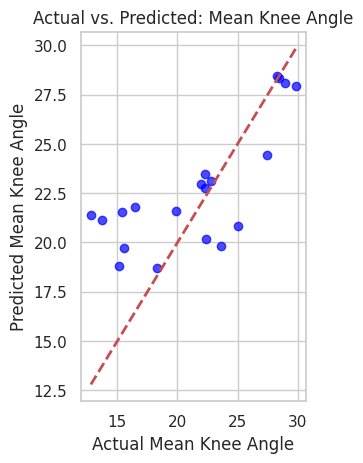

In [28]:
#VISUALIZATION  BETWEEN Actual Mean Knee Angle VS Predicted Mean Knee Angle"
plt.subplot(1, 2, 1)
plt.scatter(Y_test['mean_knee'], Y_pred[:, 0], color='blue', alpha=0.7)
plt.plot([Y_test['mean_knee'].min(), Y_test['mean_knee'].max()],
         [Y_test['mean_knee'].min(), Y_test['mean_knee'].max()], 'r--', lw=2)
plt.xlabel("Actual Mean Knee Angle")
plt.ylabel("Predicted Mean Knee Angle")
plt.title("Actual vs. Predicted: Mean Knee Angle")

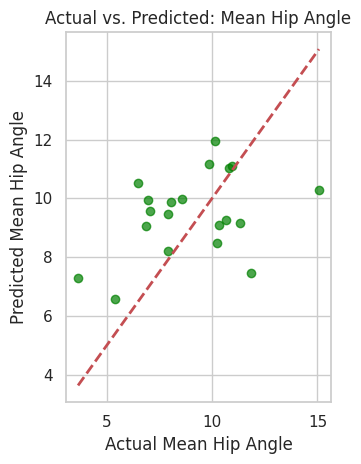

In [30]:
plt.subplot(1, 2, 2)
plt.scatter(Y_test['mean_hip'], Y_pred[:, 1], color='green', alpha=0.7)
plt.plot([Y_test['mean_hip'].min(), Y_test['mean_hip'].max()],
         [Y_test['mean_hip'].min(), Y_test['mean_hip'].max()], 'r--', lw=2)
plt.xlabel("Actual Mean Hip Angle")
plt.ylabel("Predicted Mean Hip Angle")
plt.title("Actual vs. Predicted: Mean Hip Angle")

plt.tight_layout()
plt.show()